# Setup & Libraries

In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import os
import random
import math
import timm
import torch.optim as optim
import pandas as pd

def set_seed(seed = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(888)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


# Dataset Loading

In [3]:
# resize images to 224x224 in line with ResNet input size, normalize images so mean and std are in line with pretrained statistics
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# load the dataset
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

100%|██████████| 345M/345M [00:10<00:00, 32.6MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.81MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 38.4MB/s]


In [5]:
# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Utility Functions

In [6]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0, verbose=True, model_path='model.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.verbose = verbose
        self.model_path = model_path

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1

            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return True
        return False

In [7]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Val", leave=False):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

In [8]:
def test_loop(model, loader, criterion, device):
    model.eval()
    correct = 0
    running_loss = 0.0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss = running_loss / total
    test_acc = correct / total

    return test_acc, test_loss

# Advanced Loss Functions:
1. Label Smoothing Cross Entropy Loss
2. Focal Loss

In [9]:
# HYPERPARAMETERS (from hyperparam tuning from previous section)
STRATEGY     = "full"          # full fine-tune
LR           = 1e-4
WEIGHT_DECAY = 0.05
NUM_EPOCH    = 20
PATIENCE     = 3
MIN_DELTA    = 1e-3
NUM_CLASSES  = 102
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_path = "best_vit_full_lr1e-4_wd0p05.pt"

print("Using device: ", DEVICE)

def create_vit_model():
    model = timm.create_model(
        "vit_base_patch16_224",
        pretrained=True,
        num_classes=NUM_CLASSES
    )
    model.to(DEVICE)
    return model

Using device:  cuda


## 1. Label Smoothed CE Loss

In [10]:
history_ls = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

model_ls = create_vit_model()

optimizer_ls = optim.AdamW(model_ls.parameters(),lr=LR,weight_decay=WEIGHT_DECAY)
criterion_ls = nn.CrossEntropyLoss(label_smoothing=0.1)
early_stopper_ls = EarlyStopper(patience=PATIENCE,min_delta=MIN_DELTA,verbose=True,model_path="best_vit_ls.pth")

best_val_loss_ls = float("inf")

for epoch in range(NUM_EPOCH):
    print(f"\n[LabelSmooth] Epoch {epoch+1}/{NUM_EPOCH}")

    # train
    train_loss, train_acc = train_one_epoch(
        model_ls, train_loader, optimizer_ls, criterion_ls, DEVICE
    )

    # validate
    val_loss, val_acc = eval_one_epoch(
        model_ls, val_loader, criterion_ls, DEVICE
    )

    history_ls["train_loss"].append(train_loss)
    history_ls["train_acc"].append(train_acc)
    history_ls["val_loss"].append(val_loss)
    history_ls["val_acc"].append(val_acc)

    print(f"  Train loss: {train_loss:.4f} | acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f} | acc: {val_acc:.4f}")

    # save best by val loss
    if val_loss < best_val_loss_ls:
        best_val_loss_ls = val_loss
        torch.save(model_ls.state_dict(), "best_vit_ls.pth")
        print("  (Saved best LabelSmooth model)")

    # early stopping
    if early_stopper_ls.early_stop(val_loss, model_ls):
        print(f"  Early stopping triggered at epoch {epoch+1}")
        break

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


[LabelSmooth] Epoch 1/20


  Train loss: 3.5157 | acc: 0.3069
  Val   loss: 1.5857 | acc: 0.7941
  (Saved best LabelSmooth model)

[LabelSmooth] Epoch 2/20


  Train loss: 1.1686 | acc: 0.9265
  Val   loss: 1.2575 | acc: 0.8873
  (Saved best LabelSmooth model)

[LabelSmooth] Epoch 3/20


  Train loss: 0.9125 | acc: 0.9912
  Val   loss: 1.1001 | acc: 0.9520
  (Saved best LabelSmooth model)

[LabelSmooth] Epoch 4/20


  Train loss: 0.8520 | acc: 1.0000
  Val   loss: 1.0668 | acc: 0.9608
  (Saved best LabelSmooth model)

[LabelSmooth] Epoch 5/20


  Train loss: 0.8274 | acc: 1.0000
  Val   loss: 1.0609 | acc: 0.9657
  (Saved best LabelSmooth model)

[LabelSmooth] Epoch 6/20


  Train loss: 0.8154 | acc: 1.0000
  Val   loss: 1.0582 | acc: 0.9657
  (Saved best LabelSmooth model)

[LabelSmooth] Epoch 7/20


  Train loss: 0.8087 | acc: 1.0000
  Val   loss: 1.0501 | acc: 0.9706
  (Saved best LabelSmooth model)

[LabelSmooth] Epoch 8/20


  Train loss: 0.8037 | acc: 1.0000
  Val   loss: 1.0685 | acc: 0.9686

[LabelSmooth] Epoch 9/20


  Train loss: 0.8006 | acc: 1.0000
  Val   loss: 1.0631 | acc: 0.9696

[LabelSmooth] Epoch 10/20


  Train loss: 0.7982 | acc: 1.0000
  Val   loss: 1.0538 | acc: 0.9725
Early stopping triggered.
  Early stopping triggered at epoch 10


In [11]:
model_ls.load_state_dict(torch.load("best_vit_ls.pth", map_location=DEVICE))
test_acc_ls, test_loss_ls = test_loop(model_ls, test_loader, criterion_ls, DEVICE)
print(f"[LabelSmooth] Test Acc: {test_acc_ls:.4f} | Test Loss: {test_loss_ls:.4f}")

[LabelSmooth] Test Acc: 0.9673 | Test Loss: 1.0860


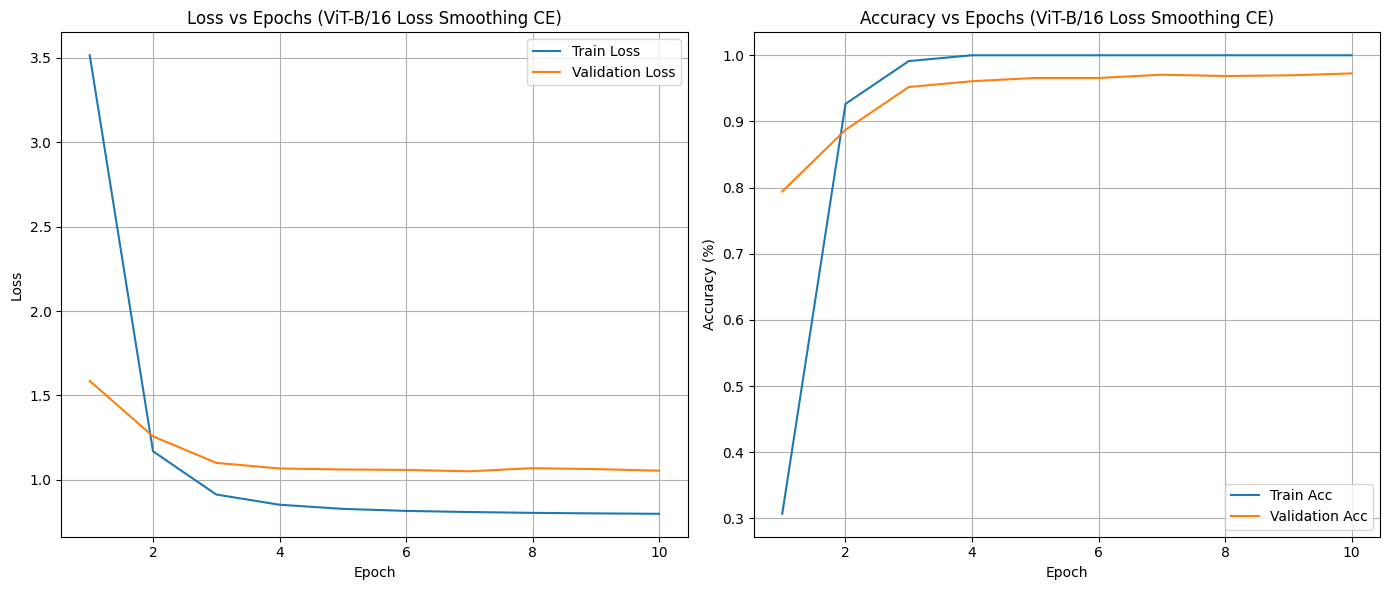

In [12]:
epochs = range(1, len(history_ls["train_loss"]) + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_ls["train_loss"], label="Train Loss")
plt.plot(epochs, history_ls["val_loss"],   label="Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs Epochs (ViT-B/16 Loss Smoothing CE)")
plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history_ls["train_acc"], label="Train Acc")
plt.plot(epochs, history_ls["val_acc"],   label="Validation Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy vs Epochs (ViT-B/16 Loss Smoothing CE)")
plt.grid(True); plt.legend()

plt.tight_layout(); plt.show()

## 2. ArcFace

In [16]:
import torch.nn.functional as F

class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.easy_margin = easy_margin

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        input = F.normalize(input, dim=1)
        weight = F.normalize(self.weight, dim=1)

        cosine = F.linear(input, weight)
        sine = torch.sqrt(1.0 - torch.clamp(cosine ** 2, 0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1.0)

        logits = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        logits = logits * self.s
        return logits


class ViTArcFace(nn.Module):
    def __init__(self, num_classes=102, s=30.0, m=0.50):
        super().__init__()
        self.backbone = timm.create_model(
            "vit_base_patch16_224",
            pretrained=True,
            num_classes=0
        )
        feat_dim = self.backbone.num_features

        self.arc_head = ArcMarginProduct(
            in_features=feat_dim,
            out_features=num_classes,
            s=s,
            m=m
        )

    def forward(self, x, labels=None):
        feats = self.backbone(x)
        feats = F.normalize(feats, dim=1)

        if labels is None:
            weight = F.normalize(self.arc_head.weight, dim=1)
            logits = F.linear(feats, weight) * self.arc_head.s
            return logits

        logits = self.arc_head(feats, labels)
        return logits


In [18]:
def train_one_epoch_arc(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, labels)   # pass labels here
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def eval_one_epoch_arc(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images, labels)   # pass labels here
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def test_loop_arc(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images, labels)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    test_loss = running_loss / total
    test_acc = correct / total
    return test_acc, test_loss


In [19]:
# HYPERPARAMETERS
STRATEGY = "full"
LR =1e-4
WEIGHT_DECAY = 0.05
NUM_EPOCH = 20
PATIENCE = 3
MIN_DELTA = 1e-3
NUM_CLASSES = 102
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion_arc = nn.CrossEntropyLoss()

history_arc = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

model_arc = ViTArcFace(num_classes=NUM_CLASSES).to(DEVICE)

optimizer_arc = torch.optim.AdamW(
    model_arc.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

early_stopper_arc = EarlyStopper(
    patience=PATIENCE,
    min_delta=MIN_DELTA,
    verbose=True,
    model_path="best_vit_arcface.pth"
)

best_val_loss_arc = float("inf")

for epoch in range(NUM_EPOCH):
    print(f"\n[ArcFace] Epoch {epoch+1}/{NUM_EPOCH}")

    train_loss, train_acc = train_one_epoch_arc(
        model_arc, train_loader, optimizer_arc, criterion_arc, DEVICE
    )

    val_loss, val_acc = eval_one_epoch_arc(
        model_arc, val_loader, criterion_arc, DEVICE
    )

    history_arc["train_loss"].append(train_loss)
    history_arc["train_acc"].append(train_acc)
    history_arc["val_loss"].append(val_loss)
    history_arc["val_acc"].append(val_acc)

    print(f"  Train loss: {train_loss:.4f} | acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f} | acc: {val_acc:.4f}")

    if val_loss < best_val_loss_arc:
        best_val_loss_arc = val_loss
        torch.save(model_arc.state_dict(), "best_vit_arcface.pth")
        print("  (Saved best ArcFace model)")

    if early_stopper_arc.early_stop(val_loss, model_arc):
        print(f"  Early stopping triggered at epoch {epoch+1}")
        break

# --- Test best ArcFace model ---
model_arc.load_state_dict(torch.load("best_vit_arcface.pth", map_location=DEVICE))
test_acc_arc, test_loss_arc = test_loop_arc(model_arc, test_loader, criterion_arc, DEVICE)
print(f"[ArcFace] Test Acc: {test_acc_arc:.4f} | Test Loss: {test_loss_arc:.4f}")



[ArcFace] Epoch 1/20
  Train loss: 17.0049 | acc: 0.0000
  Val   loss: 13.1649 | acc: 0.0000
  (Saved best ArcFace model)

[ArcFace] Epoch 2/20
  Train loss: 8.0328 | acc: 0.1333
  Val   loss: 5.0362 | acc: 0.3118
  (Saved best ArcFace model)

[ArcFace] Epoch 3/20
  Train loss: 1.4465 | acc: 0.7637
  Val   loss: 3.2389 | acc: 0.5980
  (Saved best ArcFace model)

[ArcFace] Epoch 4/20
  Train loss: 0.5728 | acc: 0.9245
  Val   loss: 2.8248 | acc: 0.6627
  (Saved best ArcFace model)

[ArcFace] Epoch 5/20
  Train loss: 0.1691 | acc: 0.9745
  Val   loss: 3.6750 | acc: 0.6196

[ArcFace] Epoch 6/20
  Train loss: 0.1127 | acc: 0.9824
  Val   loss: 2.0575 | acc: 0.7912
  (Saved best ArcFace model)

[ArcFace] Epoch 7/20
  Train loss: 0.0417 | acc: 0.9971
  Val   loss: 2.4387 | acc: 0.7598

[ArcFace] Epoch 8/20
  Train loss: 0.2045 | acc: 0.9784
  Val   loss: 2.7231 | acc: 0.7108

[ArcFace] Epoch 9/20
  Train loss: 0.3867 | acc: 0.9441
  Val   loss: 3.7825 | acc: 0.6588
Early stopping triggered.

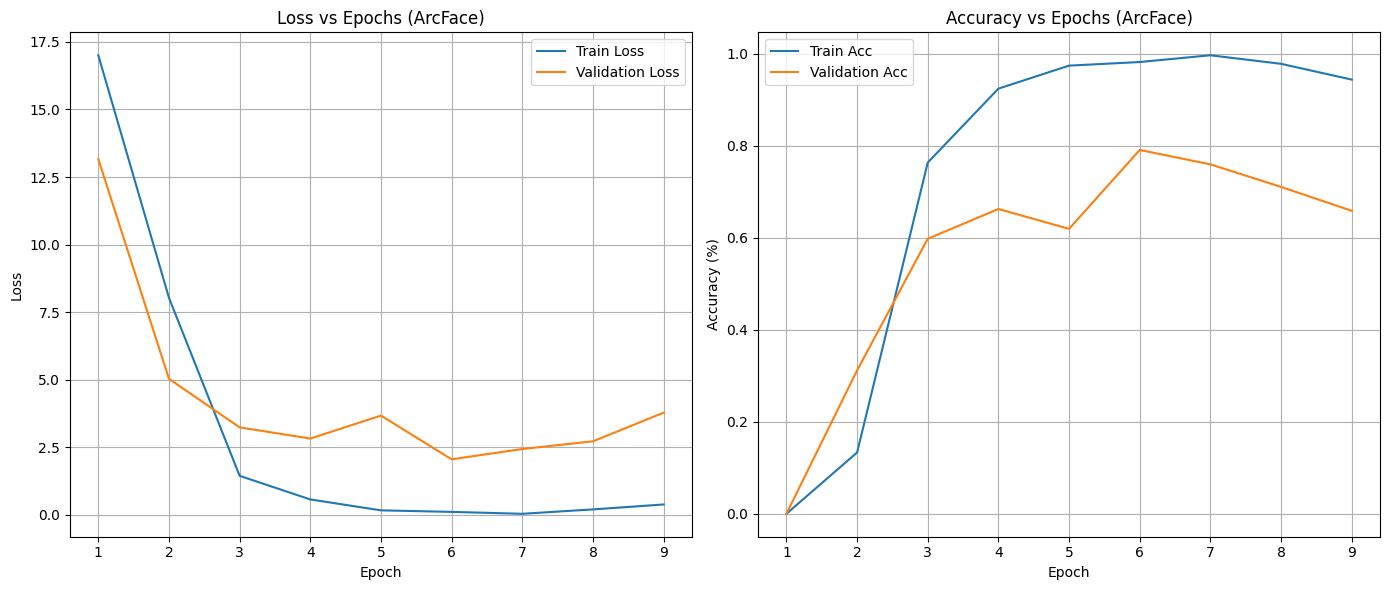

In [21]:
epochs = range(1, len(history_arc["train_loss"]) + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_arc["train_loss"], label="Train Loss")
plt.plot(epochs, history_arc["val_loss"],   label="Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs Epochs (ArcFace)")
plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history_arc["train_acc"], label="Train Acc")
plt.plot(epochs, history_arc["val_acc"],   label="Validation Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy vs Epochs (ArcFace)")
plt.grid(True); plt.legend()

plt.tight_layout(); plt.show()

# Results Comparison

In [24]:
results = {
    #"strategy":   ["full", "full"],
    "loss":       ["LabelSmooth", "ArcFace"],
    "test_acc":   [test_acc_ls, test_acc_arc],
    "test_loss":  [test_loss_ls, test_loss_arc]
}

In [25]:
df_results = pd.DataFrame(results)
print(df_results)

          loss  test_acc  test_loss
0  LabelSmooth  0.967312   1.086011
1      ArcFace  0.758660   2.281477


# Combining VPT + Label Smoothing Cross Entropy Loss
This design is not included in the report due to page limit constraints and improvements in test accuracy is not significant.

In [30]:
!pip install timm -q
!git clone https://github.com/TooTouch/VPT.git

fatal: destination path 'VPT' already exists and is not an empty directory.


In [33]:
import sys
sys.path.append("./VPT")
from models.vpt import VPT

In [34]:
NUM_CLASS = 102
PROMPT_TOKENS = 5
PROMPT_DROPOUT = 0.0
PROMPT_TYPE = 'shallow'
LR = 1e-3
WEIGHT_DECAY = 1e-4
NUM_EPOCH = 20
PATIENCE = 3

history_shallow = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

model_shallow_ls = VPT(modelname='vit_base_patch16_224',num_classes=NUM_CLASS,pretrained=True,
                    prompt_tokens=PROMPT_TOKENS, prompt_dropout=PROMPT_DROPOUT ,prompt_type=PROMPT_TYPE).to(DEVICE)

optimizer_shallow = torch.optim.AdamW(filter(lambda p: p.requires_grad, model_shallow_ls.parameters()),lr=LR,weight_decay=WEIGHT_DECAY)
criterion_vpt = nn.CrossEntropyLoss(label_smoothing=0.1)
early_stopper = EarlyStopper(patience=PATIENCE, min_delta=0.0, verbose=True, model_path="best_vpt_shallow_ls.pth")

best_val_loss = np.inf

for epoch in range(NUM_EPOCH):
    print(f"\n[Shallow] Epoch {epoch+1}/{NUM_EPOCH}")

    train_loss, train_acc = train_one_epoch(model_shallow_ls, train_loader, optimizer_shallow, criterion_vpt, DEVICE)

    val_loss, val_acc = eval_one_epoch(model_shallow_ls, val_loader, criterion_vpt, DEVICE)

    history_shallow["train_loss"].append(train_loss)
    history_shallow["train_acc"].append(train_acc)
    history_shallow["val_loss"].append(val_loss)
    history_shallow["val_acc"].append(val_acc)

    print(f"  Train loss: {train_loss:.4f} | acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f} | acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_shallow_ls.state_dict(), "best_vpt_shallow.pth")
        print("  (Saved best shallow model)")

    if early_stopper.early_stop(val_loss, model_shallow_ls):
        print(f"  Early stopping triggered at epoch {epoch+1}")
        break




[Shallow] Epoch 1/20


  Train loss: 3.0860 | acc: 0.4804
  Val   loss: 1.3364 | acc: 0.9235
  (Saved best shallow model)

[Shallow] Epoch 2/20


  Train loss: 1.0439 | acc: 0.9833
  Val   loss: 1.0876 | acc: 0.9686
  (Saved best shallow model)

[Shallow] Epoch 3/20


  Train loss: 0.9251 | acc: 1.0000
  Val   loss: 1.0616 | acc: 0.9735
  (Saved best shallow model)

[Shallow] Epoch 4/20


  Train loss: 0.8798 | acc: 1.0000
  Val   loss: 1.0605 | acc: 0.9735
  (Saved best shallow model)

[Shallow] Epoch 5/20


  Train loss: 0.8600 | acc: 1.0000
  Val   loss: 1.0531 | acc: 0.9745
  (Saved best shallow model)

[Shallow] Epoch 6/20


  Train loss: 0.8467 | acc: 1.0000
  Val   loss: 1.0461 | acc: 0.9765
  (Saved best shallow model)

[Shallow] Epoch 7/20


  Train loss: 0.8374 | acc: 1.0000
  Val   loss: 1.0447 | acc: 0.9765
  (Saved best shallow model)

[Shallow] Epoch 8/20


  Train loss: 0.8306 | acc: 1.0000
  Val   loss: 1.0429 | acc: 0.9755
  (Saved best shallow model)

[Shallow] Epoch 9/20


  Train loss: 0.8254 | acc: 1.0000
  Val   loss: 1.0407 | acc: 0.9765
  (Saved best shallow model)

[Shallow] Epoch 10/20


  Train loss: 0.8211 | acc: 1.0000
  Val   loss: 1.0399 | acc: 0.9775
  (Saved best shallow model)

[Shallow] Epoch 11/20


  Train loss: 0.8181 | acc: 1.0000
  Val   loss: 1.0373 | acc: 0.9784
  (Saved best shallow model)

[Shallow] Epoch 12/20


  Train loss: 0.8150 | acc: 1.0000
  Val   loss: 1.0365 | acc: 0.9755
  (Saved best shallow model)

[Shallow] Epoch 13/20


  Train loss: 0.8127 | acc: 1.0000
  Val   loss: 1.0362 | acc: 0.9765
  (Saved best shallow model)

[Shallow] Epoch 14/20


  Train loss: 0.8107 | acc: 1.0000
  Val   loss: 1.0331 | acc: 0.9784
  (Saved best shallow model)

[Shallow] Epoch 15/20


  Train loss: 0.8090 | acc: 1.0000
  Val   loss: 1.0325 | acc: 0.9824
  (Saved best shallow model)

[Shallow] Epoch 16/20


  Train loss: 0.8073 | acc: 1.0000
  Val   loss: 1.0348 | acc: 0.9775

[Shallow] Epoch 17/20


  Train loss: 0.8059 | acc: 1.0000
  Val   loss: 1.0347 | acc: 0.9804

[Shallow] Epoch 18/20


  Train loss: 0.8046 | acc: 1.0000
  Val   loss: 1.0322 | acc: 0.9814
  (Saved best shallow model)

[Shallow] Epoch 19/20


  Train loss: 0.8036 | acc: 1.0000
  Val   loss: 1.0325 | acc: 0.9775

[Shallow] Epoch 20/20


  Train loss: 0.8027 | acc: 1.0000
  Val   loss: 1.0333 | acc: 0.9794


In [35]:
test_acc, test_loss = test_loop(model_shallow_ls, test_loader, criterion_vpt, DEVICE)
print(f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Test Acc: 0.9725, Test Loss: 1.0728
